# Setup

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [67]:
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import mean_squared_error
import matplotlib as mpl
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

def print3D(x, y, z=None, c='b'):
    if z is None:
        plt.scatter(x,y, c=c)
    else:
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(x, y, z, c=c)

**Сгенирирум данные**

In [47]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

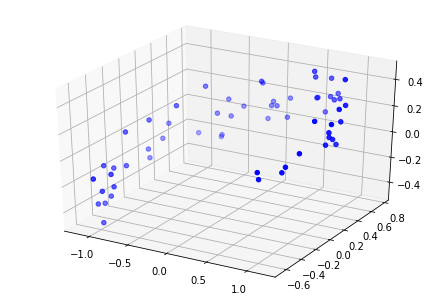

In [90]:
print3D(X[:, 0], X[:, 1], X[:, 2])

# PCA

## Introduce PCA

[0.93636116 0.29854881 0.18465208]
[-0.34027485  0.90119108  0.2684542 ]


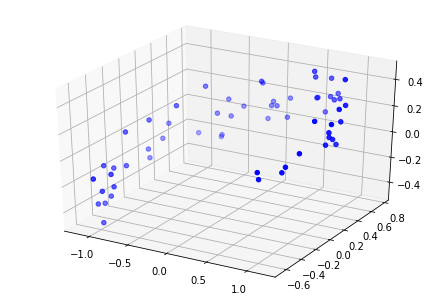

In [99]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

print3D(X[:, 0], X[:, 1], X[:, 2])
print(c1)
print(c2)

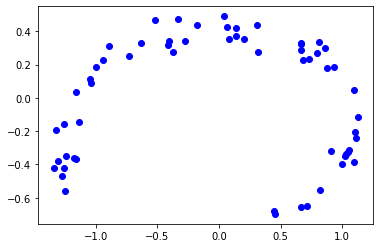

In [97]:
W2 = Vt[:2].T
X2D = np.matmul(X_centered, W2)
print3D(X2D[:, 0], X2D[:, 1])

## PCA in SKLean

pca principal components:
 [[-0.93636116 -0.29854881 -0.18465208]
 [ 0.34027485 -0.90119108 -0.2684542 ]]
principal components calculated manually:
 [[ 0.93636116  0.29854881  0.18465208]
 [-0.34027485  0.90119108  0.2684542 ]]


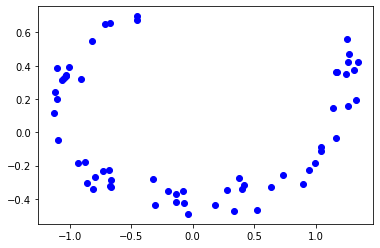

In [98]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
print3D(X2D[:, 0], X2D[:, 1])

print("pca principal components:\n", pca.components_)
print("principal components calculated manually:\n", W2.T)

Визуально результат такой же как и в предыдущем методе. Вектор pc отличается только направлением (что визуально можно наблюдать)

In [100]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

# PCA

### Choosing the Right Number of Dimensions

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

x = mnist["data"]
y = mnist["target"]

x_train, x_test, y_train, y_test = train_test_split(x, y)

Определим размерность, при которой сохраняется 95% вариативности данных. 

In [14]:
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.argmax(cumsum >= 0.95) + 1
print("Number of Dimensions:", dim)

Number of Dimensions: 154


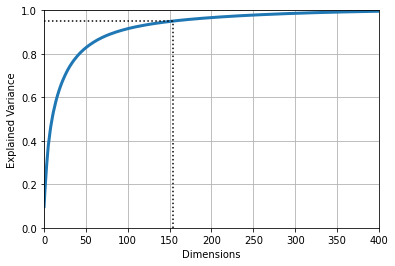

In [17]:
plt.axis([0, 400, 0, 1])
plt.plot(cumsum, linewidth=3)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([dim, dim], [0, 0.95], "k:")
plt.plot([0, dim], [0.95, 0.95], "k:")
plt.grid(True)

Аналогичного результата можно добавиться, указав значение вариативности в аргументах PCA

In [15]:
pca = PCA(n_components=0.95)
pca.fit(x_train)
print("Number of Dimensions:", dim)

Number of Dimensions: 154


Проверим на каком-нибудь классификаторе

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

forest = RandomForestClassifier(random_state=42, n_jobs=-1)
forest.fit(x_train, y_train)

y_pred = forest.predict(x_test)
score = accuracy_score(y_test, y_pred)
print("accuracy of full dataset dimentional:", score)

accuracy of full dataset dimentional: 0.9682285714285714


In [19]:
forest = RandomForestClassifier(random_state=42, n_jobs=-1)
forest.fit(pca.transform(x_train), y_train)

y_pred = forest.predict(pca.transform(x_test))
score = accuracy_score(y_test, y_pred)
print("accuracy with 154 dataset dimentionality:", score)

accuracy with 154 dataset dimentionality: 0.9473142857142857


In [24]:
pca = PCA(n_components=100)
pca.fit(x_train)

forest = RandomForestClassifier(random_state=42, n_jobs=-1)
forest.fit(pca.transform(x_train), y_train)

y_pred = forest.predict(pca.transform(x_test))
score = accuracy_score(y_test, y_pred)
print("accuracy with 100 dataset dimentionality:", score)

accuracy with 100 dataset dimentionality: 0.9477142857142857


In [25]:
pca = PCA(n_components=60)
pca.fit(x_train)

forest = RandomForestClassifier(random_state=42, n_jobs=-1)
forest.fit(pca.transform(x_train), y_train)

y_pred = forest.predict(pca.transform(x_test))
score = accuracy_score(y_test, y_pred)
print("accuracy with 60 dataset dimentionality:", score)

accuracy with 60 dataset dimentionality: 0.9501714285714286


### PCA для сжатия даных

In [78]:
pca = PCA(n_components=0.95)
x_reduced   = pca.fit_transform(x_train)
x_recovered = pca.inverse_transform(x_reduced)

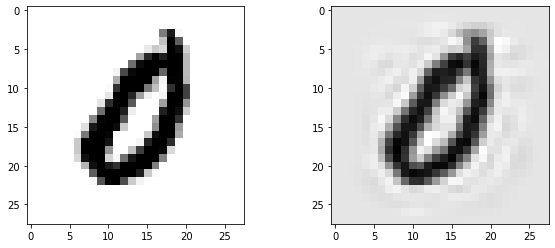

In [79]:
plt.figure(figsize=(10, 4))

ax1 = plt.subplot(121)
img = x_train[0].reshape(28,28)
plt.imshow(img, cmap = mpl.cm.binary, interpolation="nearest")

ax2 = plt.subplot(122)
img = x_recovered[0].reshape(28,28)
plt.imshow(img, cmap = mpl.cm.binary, interpolation="nearest")

plt.show()

reconstruction error

In [82]:
error = mean_squared_error(x_recovered, x_train)
print("Reconstruction error:", error)

Reconstruction error: 217.17071646959278


### Randomized PCA

In [86]:
import time

start_time = time.time()
rnd_pca = PCA(n_components=100, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(x_train)
print("Randomized PCA time:", time.time() - start_time)

start_time = time.time()
pca = PCA(n_components=100, svd_solver="full")
X_reduced = pca.fit_transform(x_train)
print("Common PCA time:", time.time() - start_time)

Randomized PCA time: 12.923720598220825
Common PCA time: 30.051116943359375


### Incremental PCA

In [88]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100 #кол-во экземпляров данных в пакете
inc_pca = IncrementalPCA(n_components=154)

for batch in np.array_split(x_train, n_batches):
    inc_pca.partial_fit(batch)
    x_reduced = inc_pca.transform(x_train)

# Kernal PCA

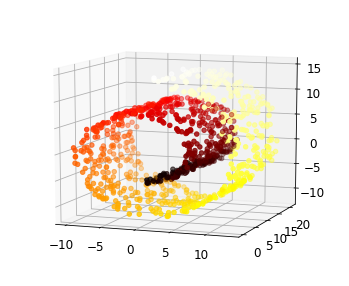

In [24]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.view_init(10, -70)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
plt.show()

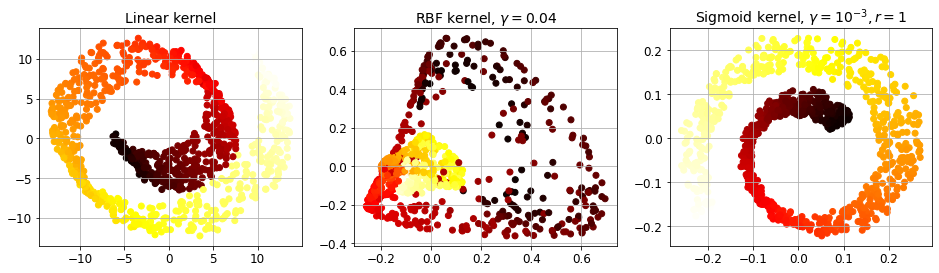

In [5]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

plt.figure(figsize=(16, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), 
                            (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    x_ = pca.fit_transform(X)
    plt.subplot(subplot)
    plt.grid(True)
    plt.scatter(x_[:, 0], x_[:, 1], c=t, cmap=plt.cm.hot)
    plt.title(title, fontsize=14)    

**Подбираем гиперпараметры PCA**

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

y = t > 6.9

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

clf.fit(X, y)
y_pred = clf.predict(X)
acc = accuracy_score(y, y_pred)
print("accuracy before using grid seach:", acc)

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X, y)

print("grid search best params:\n", grid_search.best_params_)

y_pred = grid_search.best_estimator_.predict(X)
acc = accuracy_score(y, y_pred)
print("accuracy using best params of grid seach:", acc)

accuracy before using grid seach: 0.711
grid search best params:
 {'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}
accuracy using best params of grid seach: 0.952


**Использование подхода оценки ошибки реконструкции данных**

In [81]:
pca = KernelPCA(n_components=2, gamma=0.4, kernel='rbf', 
                fit_inverse_transform=True)
x_reduced = pca.fit_transform(X)
x_pre_img = pca.inverse_transform(x_reduced)
mean_squared_error(x_pre_img, X)

41.562780441692304

In [139]:
pca = KernelPCA(n_components=2, fit_inverse_transform=True)
x_reduced = pca.fit_transform(X)
x_pre_img = pca.inverse_transform(x_reduced)
mean_squared_error(x_pre_img, X)

51.58463490232133

**Использование GreadSerch для поиска гиперпарамтеров kPCA**

In [138]:
from sklearn.metrics import mean_squared_error

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

def error_func(estimator, x, y=None):
    x_ = estimator.transform(x)
    x_pre_img = estimator.inverse_transform(x_)
    err = mean_squared_error(x, x_pre_img)
    print(err)
    return -err

kpca = KernelPCA(n_components=2, fit_inverse_transform=True, n_jobs=-1)
param_grid = [{
        "gamma": np.linspace(0.03, 0.05, 10),
        "kernel": ["rbf", "sigmoid"]
    }]
grid_search = GridSearchCV(kpca, param_grid, scoring=error_func, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(X)
grid_search.best_params_

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    5.0s finished


{'gamma': 0.05, 'kernel': 'sigmoid'}

In [141]:
x_reduced = grid_search.best_estimator_.transform(X)
x_pre_img = grid_search.best_etstimator_.inverse_transform(x_reduced)
mean_squared_error(x_pre_img, X)

21.242715414426858

In [143]:
reg = LogisticRegression(solver="lbfgs")
x_pca = grid_search.best_estimator_.transform(X)
reg.fit(x_pca, y)

y_pred = reg.predict(x_pca)
acc = accuracy_score(y, y_pred)
print("accuracy:", acc)

accuracy: 0.729


Видимо этот не тот случай, где поход использования метода подбора гиперпараметров с помощью fit_inverse_transform=True, а именно использования встроенного в класс KernelPCA предсказателя для последующего сравнения прообраза (pre-image) и исходных данных дает хорошие результаты для LogisticRegression и данных вида "швейцарский ролл".

# Locally Linear Embedding (LLE)

In [144]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [147]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

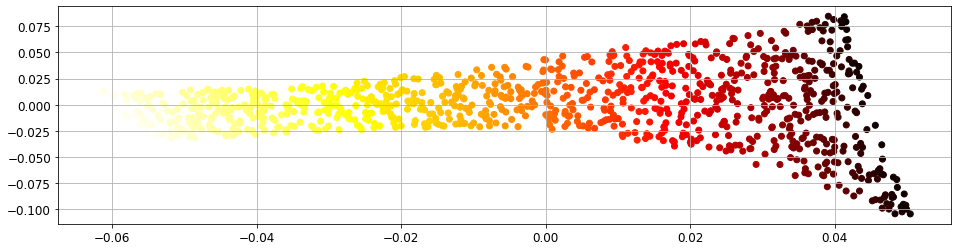

In [148]:
plt.figure(figsize=(16, 4))
plt.grid(True)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)

# Tasks

### task 1

What are the main motivations for reducing a dataset’s dimensionality? What are the main drawbacks?

плосы: 
- позволяет ускорить процесс обучения
- визуализировать данные для последующего анализа
- выполнить компрессию данных

минусы:
- потеря информации;
- увеличение вычислительной нагрузки как в процессе обучения, так и для готового предсказателя - всегда дополнительно сокращать размерность входных данных

### task 2

What is the curse of dimensionality?

Данные с большой размерностью имеют риск находиться слишком далеко друг от друга. Это же касается новых объектов, для которых выполняется предсказание. Получается так, что модель плохо обобщена, поскольку расстояния между элементами в обучающем наборе очень велки (при очень большой размерности). Таким образом модели с высокой размерностью имеют тенденцию к переобучению. 

### task 3